In [15]:
import os
import requests
import numpy as np
import jax
import jax.numpy as jnp
from jax import random
import flax.linen as nn
import optax
from jax import value_and_grad
import pickle
import pandas as pd

from helper_funcs import get_batch, generate, masked_fill, loss_fn, get_vector_batch, encode, decode
from tqdm import tqdm
import matplotlib.pyplot as plt
print(jax.devices())

[CudaDevice(id=0)]


## Parameter Selection

The Parameters used below are a scaled down version of GPT-2. GPT-2 has 4 different sizes, small, medium, large and xl. This GPT-2 could be considered an extra-small version. Note that these models may not be able to fit into RAM on your device. The exact specifications of the different sized models are shown below:

### GPT-2 Small
- n_embed: 768
- block_size: 1024
- num_heads: 12
- num_layers: 12
- vocab_size: 50257 (uses Tiktoken vocab)

### GPT-2 Medium
- n_embed: 1024
- block_size: 1024
- num_heads: 16
- num_layers: 24
- vocab_size: 50257 (uses Tiktoken vocab)

### GPT-2 Large
- n_embed: 1280
- block_size: 1024
- num_heads: 20
- num_layers: 36
- vocab_size: 50257 (uses Tiktoken vocab)

### GPT-2 XL
- n_embed: 1600
- block_size: 1024
- num_heads: 25
- num_layers: 48
- vocab_size: 50257 (uses Tiktoken vocab)

In [2]:
n_embed = 32 # Number of embedding dimensions
batch_size = 4 # How many independent sequences will we process in parallel?
block_size = 48 # What is the maximum context length for predictions?
num_heads = 4 # Number of heads in the multi-headed block
num_layers = 6 # Number of transformer decoder blocks
drop_rate = 0.1 # Dropout rate for regularization

rng_key = jax.random.PRNGKey(128)

## Data Preparation

In [3]:
with open('vocab.pickle', 'rb') as f:
    loaded_data = pickle.load(f)

vocab_size = len(loaded_data['vocab'])
print(vocab_size)

X = pd.read_parquet("X.parquet")
X

4143


,Power demand,temp,dwpt,rhum,wdir,wspd,pres,cluster,next_cluster,vector_id
0,1975.541667,8.0,6.90,93.0,0.0,0.0,1017.00,48,48,0
1,1805.590000,8.0,6.90,93.0,0.0,0.0,1017.00,48,48,0
2,1665.914167,7.5,6.25,92.0,0.0,0.0,1018.05,48,48,0
3,1607.331667,7.0,6.30,95.5,0.0,0.0,1018.05,48,48,0
4,1676.528333,6.5,6.50,100.0,0.0,0.0,1017.00,48,48,0
...,...,...,...,...,...,...,...,...,...,...
27662,3257.203333,23.6,5.45,31.0,320.0,14.8,1017.95,154,154,0
27663,3146.193333,23.1,3.95,29.0,325.0,13.9,1017.45,154,154,0
27664,3123.719167,23.0,1.90,25.0,325.0,13.0,1017.00,154,154,0
27665,3265.730000,22.5,2.50,27.0,320.0,13.0,1016.90,154,154,0


In [5]:
# Test
df_slice = X.iloc[100:124]

v = encode(df_slice)
v

[40, 41, 0, 0, 0, 0, 0, 0, 42, 0, 43, 44, 45, 46, 0, 47, 0]

In [6]:
decode(v, X)

,Power demand,temp,dwpt,rhum,wdir,wspd,pres,cluster,next_cluster
0,3034.240000,16.8,16.15,96.0,75.0,9.4,1018.45,87.0,241.0
1,3094.237500,17.8,16.65,93.0,65.0,8.5,1017.45,241.0,165.0
2,3094.237500,17.8,16.65,93.0,65.0,8.5,1017.45,241.0,165.0
3,3094.237500,17.8,16.65,93.0,65.0,8.5,1017.45,241.0,165.0
4,3094.237500,17.8,16.65,93.0,65.0,8.5,1017.45,241.0,165.0
5,3094.237500,17.8,16.65,93.0,65.0,8.5,1017.45,241.0,165.0
6,3094.237500,17.8,16.65,93.0,65.0,8.5,1017.45,241.0,165.0
7,3094.237500,17.8,16.65,93.0,65.0,8.5,1017.45,241.0,165.0
8,3200.609167,17.5,16.50,94.0,70.0,8.5,1015.00,165.0,87.0
9,3200.609167,17.5,16.50,94.0,70.0,8.5,1015.00,165.0,87.0


## Build the Attention Model

In [7]:
from attention_model import *

In [8]:
model = GPT2(vocab_size, n_embed, block_size, num_heads, num_layers, drop_rate)
dummy_x = jnp.zeros(shape=(batch_size, block_size), dtype=jnp.uint16)
variables = model.init(rng_key, dummy_x)

In [9]:
out = model.apply(variables, dummy_x)
print(out.shape)

(4, 48, 4143)


## Time Series Generation Pre-Training

In [10]:
index_seq = jnp.zeros(shape=(1,1), dtype=jnp.uint16)
max_new_tokens = 24

generated_indices = generate(variables, model.apply, index_seq, rng_key, vocab_size, 1, block_size, max_new_tokens)
generated_indices = list(np.array(generated_indices[0]))
decode(generated_indices, X)

,Power demand,temp,dwpt,rhum,wdir,wspd,pres,cluster,next_cluster
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,4799.307500,31.00,4.30,18.5,0.0,0.00,1008.00,8.0,99.0
2,2337.186667,18.80,11.05,61.0,140.0,2.70,1014.10,62.0,226.0
3,5904.695000,43.50,3.75,9.0,300.0,17.70,997.55,60.0,177.0
4,3578.605000,23.00,12.75,52.5,170.0,8.50,1004.00,15.0,120.0
5,3229.540833,17.60,16.30,92.0,160.0,5.40,1016.15,92.0,182.0
6,3318.219167,25.80,23.55,88.0,95.0,11.20,1004.75,217.0,14.0
7,4093.055000,20.00,13.90,68.0,0.0,0.00,1012.00,274.0,1.0
8,3095.494167,9.10,8.25,94.5,125.0,6.50,1017.50,243.0,250.0
9,5276.454167,30.90,26.90,79.5,40.0,14.80,1002.60,224.0,93.0


## Train the Model

In [11]:
optimizer = optax.adamw(learning_rate=1e-3)
opt_state = optimizer.init(variables)

In [ ]:
steps = 300
train_ids = X['vector_id'].to_numpy()
losses = []

pbar = tqdm(range(steps))
for step in pbar:
    rng_key, subkey = jax.random.split(rng_key)
    xb, yb = get_vector_batch(train_ids, subkey, batch_size, block_size)

    loss, grads = value_and_grad(loss_fn, argnums=(0))(
        variables, 
        model.apply,
        xb, 
        yb
    )
    updates, opt_state = optimizer.update(grads, opt_state, variables)
    variables = optax.apply_updates(variables, updates) 
    losses.append(loss)
    
    pbar.set_description(f"Epoch: {step}, Loss: {loss :.4f}")

# Save model
model_file = {
    "epoch": step,
    "variables": variables,
    "losses": losses,
    "opt_state": opt_state,
}

with open('model.pickle', 'wb') as f:
    pickle.dump(model_file, f)

Epoch: 299, Loss: 4.4887: 100%|██████████| 300/300 [06:12<00:00,  1.24s/it]


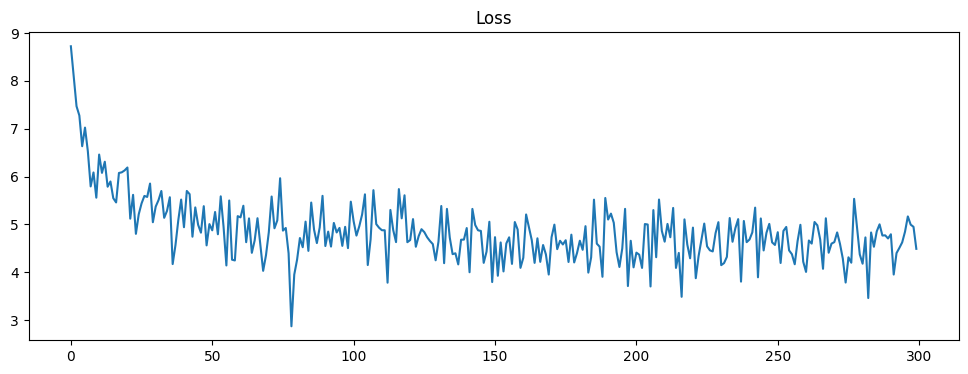

In [13]:
plt.figure(figsize=(12, 4))
plt.plot(losses)
plt.title('Loss')
plt.show()

## Time Series Generation Post-Training

In [31]:
key = random.PRNGKey(42)
max_new_tokens = 32
t = 100

# Select a random batch (t)
X_test = X.iloc[t:t+max_new_tokens]
Y_test = X.iloc[t+max_new_tokens+1:t+max_new_tokens+max_new_tokens+1].reset_index()
x = [encode(X_test)]
index_seq = jnp.array(x)

print(index_seq.shape)
print(index_seq)

(1, 25)
[[40 41  0  0  0  0  0  0 42  0 43 44 45 46  0 47  0 48  0 27  0 49  0 38
  50]]


In [32]:
rng_key, subkey = jax.random.split(rng_key)
generated_indices = generate(variables, model.apply, index_seq, rng_key, vocab_size, 1, block_size, max_new_tokens)
generated_indices = list(np.array(generated_indices[0]))
Y = decode(generated_indices, X)

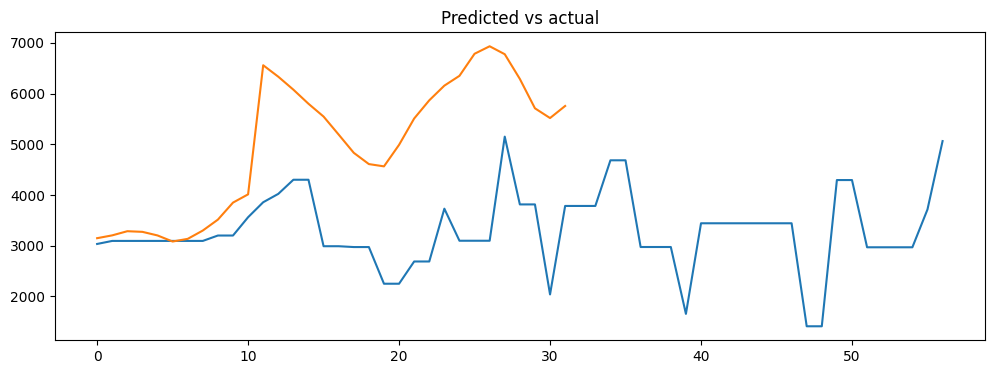

In [33]:
plt.figure(figsize=(12, 4))
plt.plot(Y.index, Y['Power demand'])
plt.plot(Y_test.index, Y_test['Power demand'])
plt.title('Predicted vs actual')
plt.show()